## CIND 820 - Data Science Project
Houssain Alali

### The problem
<img src=https://storage.googleapis.com/kaggle-media/competitions/santander/atm_image.png width="400">
At Santander our mission is to help people and businesses prosper. We are always looking for ways to help our customers understand their financial health and identify which products and services might help them achieve their monetary goals.
Our data science team is continually challenging our machine learning algorithms, working with the global data science community to make sure we can more accurately identify new ways to solve our most common challenge, binary classification problems such as: is a customer satisfied? Will a customer buy this product? Can a customer pay this loan?
In this challenge, we invite Kagglers to help us identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem.

### Supporting Libraries

In [1]:
#Supporting Libraries
import os
import pandas
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime 
from datetime import timedelta

from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import BaseEstimator, TransformerMixin

#Inline plots
%matplotlib inline 

#Constants
RANDOM_SEED=42
TEST_SIZE=0.2
#BASE_DATASET_DIR="./datasets/santander-customer-transaction-prediction"
BASE_DATASET_DIR="./datasets"
BASE_MODEL_DIR='./models'
SANTANDER_TRAINING_SET_FILNAME = "train.csv"

#Control execution
PLOT_HIST=True
PLOT_CORRELATION = True

### Load trainning set data and run quick inspection

In [2]:
#Load Training Set
training_file = os.path.join(BASE_DATASET_DIR, SANTANDER_TRAINING_SET_FILNAME)
df= pd.read_csv(training_file)
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [3]:
# check for missing values in the DataFrame
print(df.isnull().sum())

if df.isnull().sum().any():
    print("Missing data exist")
else:
    print("No missing data in dataset")

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64
No missing data in dataset


In [4]:
#Look at the basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


### Check the data

In [5]:
df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


Target values
0    179902
1     20098
Name: target, dtype: int64


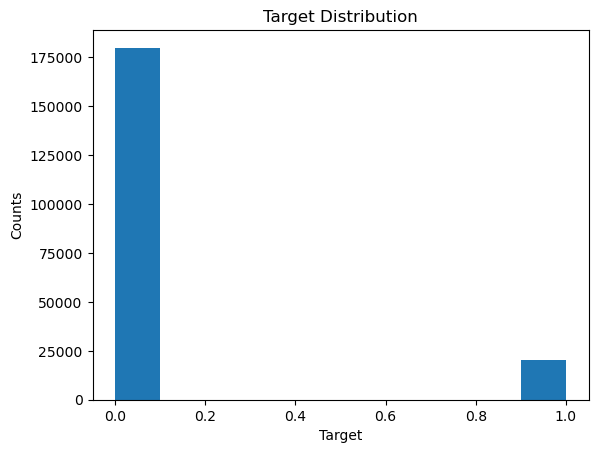

In [6]:
#Check the data distribution for the target type
plt.hist(df["target"])
plt.xlabel('Target')
plt.ylabel('Counts')
plt.title('Target Distribution')
print("Target values")
print(df["target"].value_counts())

The target distribution is unbalanced, hence stratified sampling will be applied

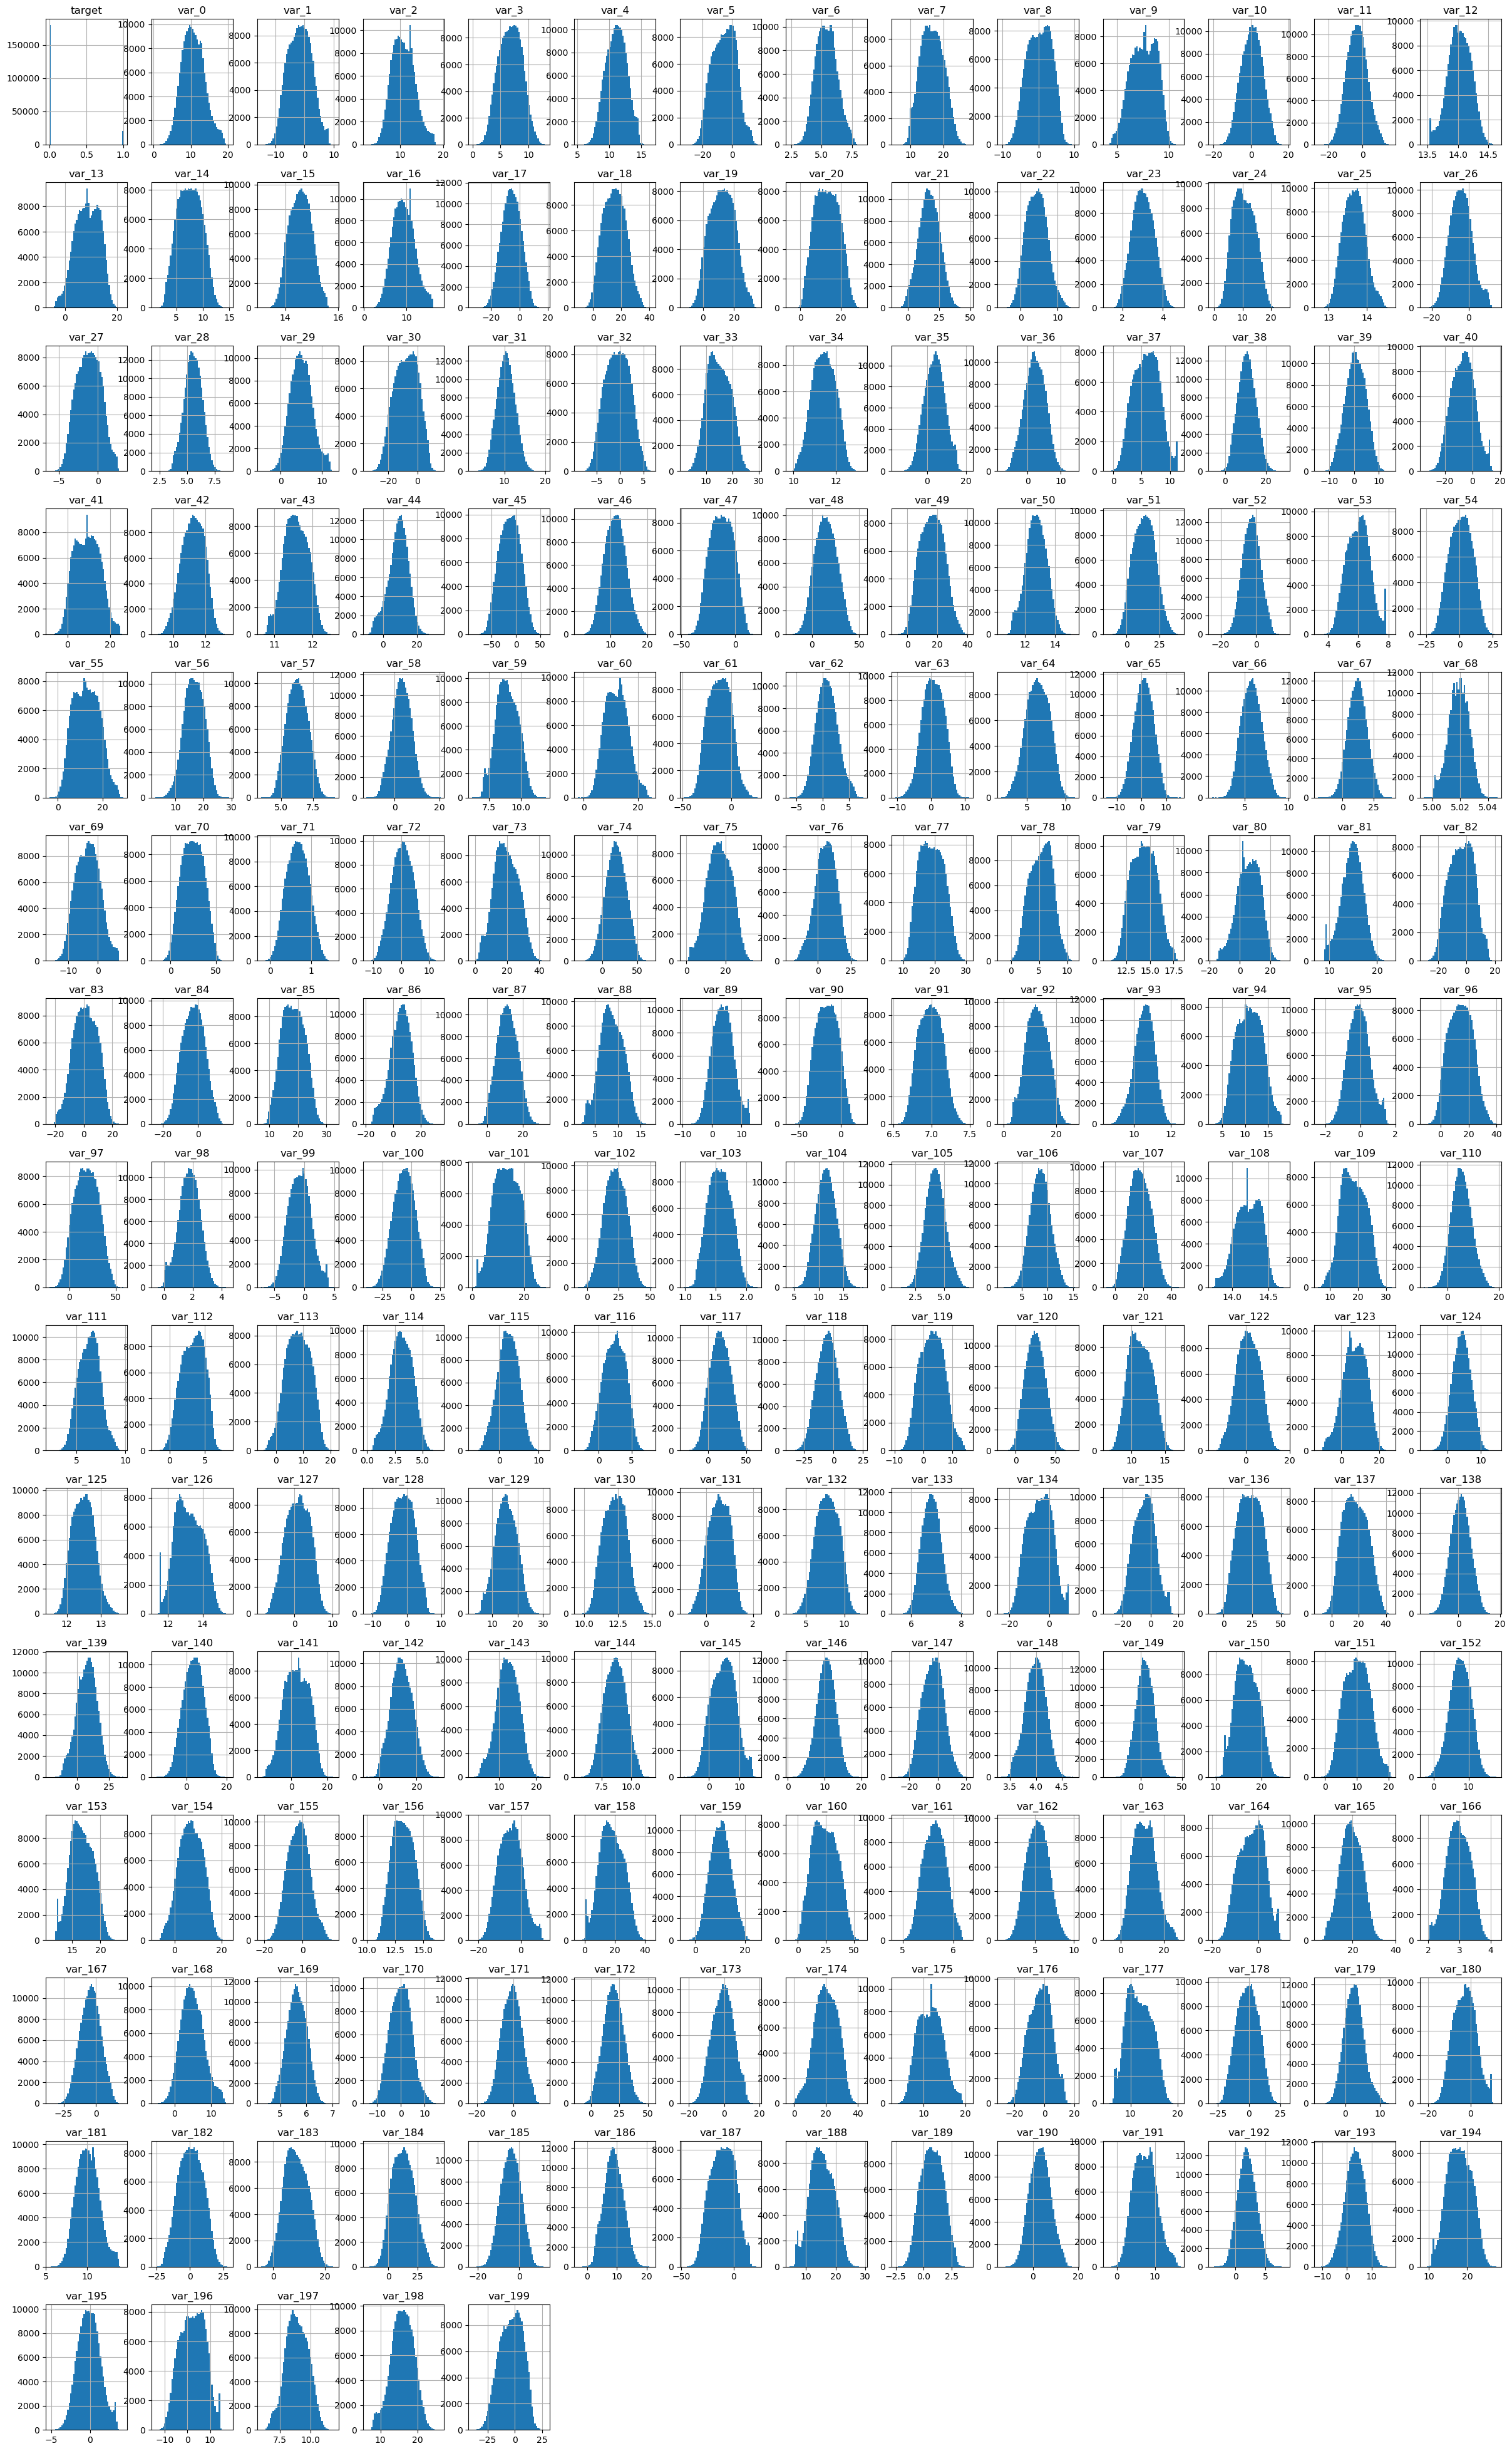

In [7]:
if PLOT_HIST == True:
    df.hist(bins=50, figsize=(30,50))
    plt.show()

The correlation matrix is plotted in order to look for any further relationships on the data

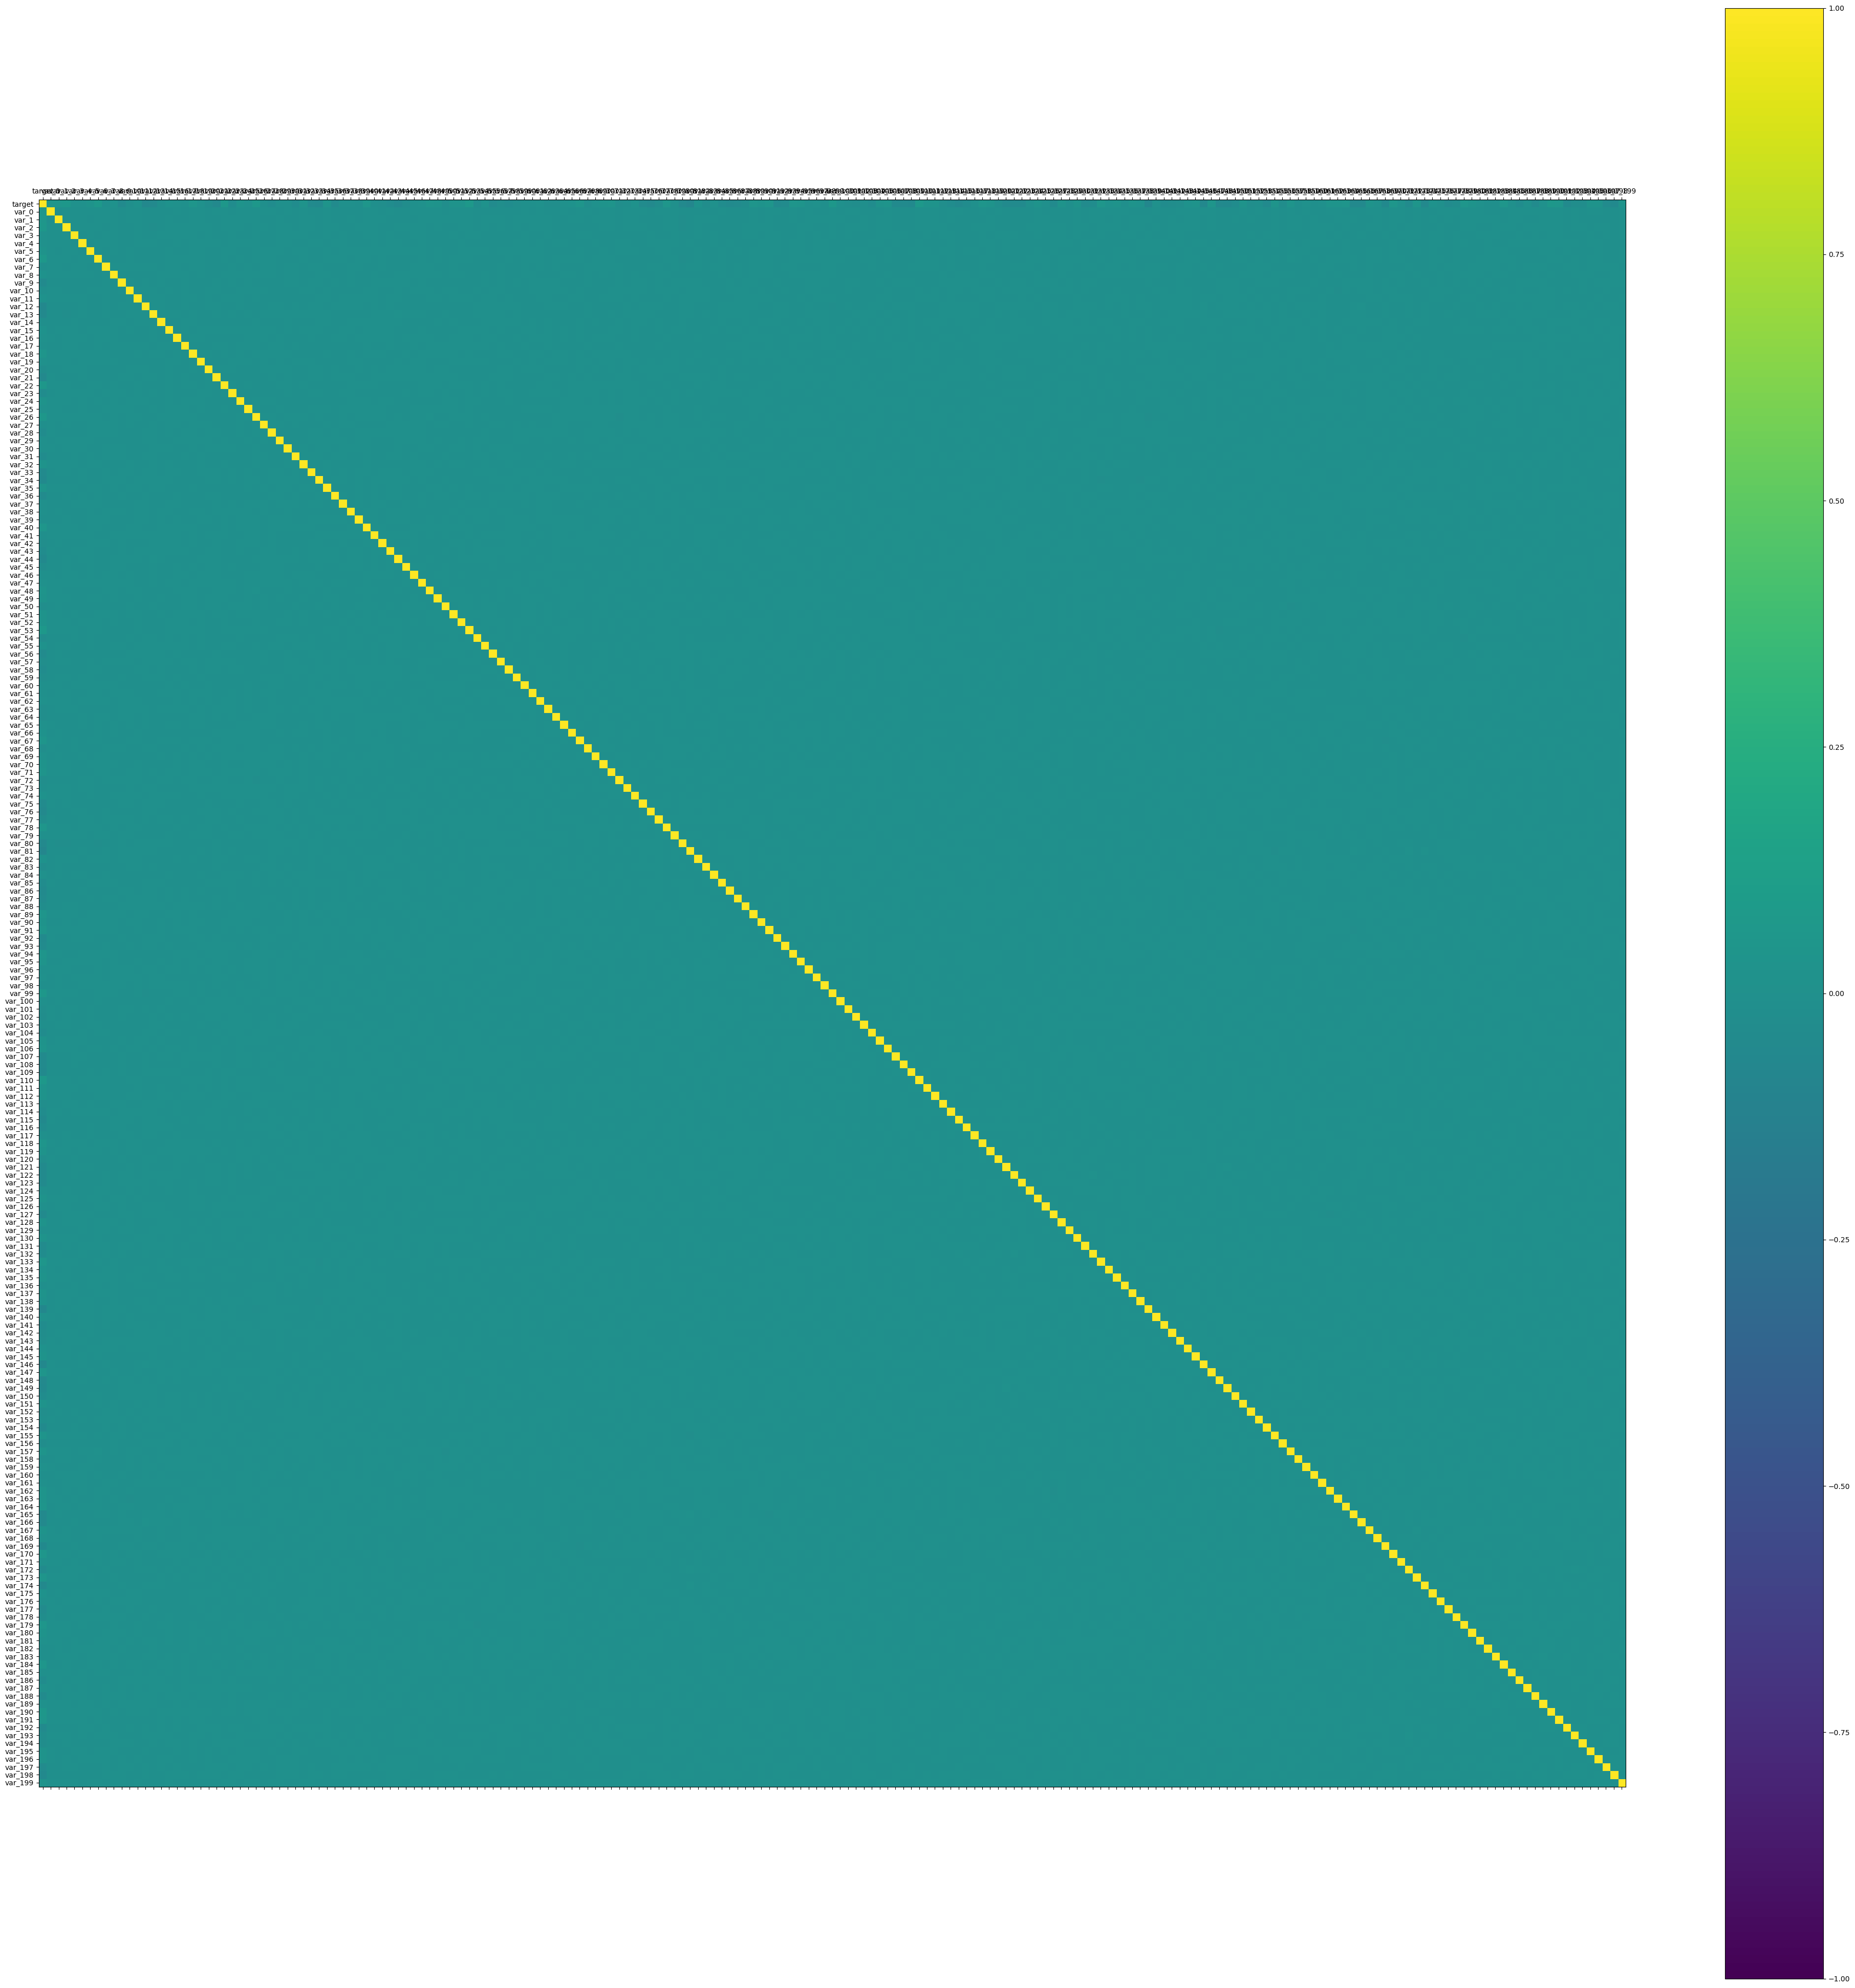

In [8]:
if PLOT_CORRELATION == True:
    # Correction Matrix Plot
    correlations = df.drop(['ID_code'], axis=1).corr()

    # plot correlation matrix
    fig = plt.figure(figsize=(50,50))
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, len(df.columns.values[1:]), 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(df.columns.values[1:])
    ax.set_yticklabels(df.columns.values[1:])
    plt.show()

The features distributions seem reasonsable (not obvious outliers), normalization will be done and since the number of samples per class is not balanced I will use stratified sampling to split the training set on two (training and test) 

### Normalize data, split and ready it for model training

In [9]:
#(1) Drop the drop 'ID_code' column first
x = df.drop(['ID_code'], axis=1)

#(2) Normalize the data
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)


In [10]:
#Re-build dataframe with normalized data 
df_clean = pandas.DataFrame(x_scaled)
df_clean.columns = df.drop(['ID_code'], axis=1).columns.values
df_clean.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0.0,0.427853,0.324824,0.568059,0.388041,0.550670,0.467321,0.454298,0.594255,0.270395,...,0.569515,0.342943,0.568958,0.448173,0.510975,0.300318,0.678981,0.430958,0.327658,0.560645
1,0.0,0.557212,0.428639,0.681235,0.410417,0.628408,0.795072,0.536604,0.500584,0.660911,...,0.668079,0.536531,0.523717,0.756190,0.350211,0.765154,0.686614,0.468277,0.609546,0.605827
2,0.0,0.411969,0.483777,0.578061,0.599690,0.474941,0.471329,0.753295,0.414724,0.270429,...,0.522496,0.643141,0.448960,0.448000,0.671183,0.881350,0.236337,0.381950,0.425833,0.582736
3,0.0,0.535099,0.507140,0.396562,0.546993,0.647586,0.616822,0.572995,0.428577,0.224846,...,0.570474,0.383085,0.370986,0.439205,0.745555,0.418549,0.346810,0.717176,0.590016,0.443232
4,0.0,0.473637,0.533434,0.624133,0.504796,0.621079,0.702836,0.589011,0.622220,0.811883,...,0.387371,0.629275,0.299888,0.697737,0.238801,0.393218,0.557507,0.586526,0.591416,0.446041


In [11]:
#(3) Do stratified sampling on 'target' (80% training and 20% test)
split = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_SEED)
for train_index, test_index in split.split(df_clean, df_clean["target"]):
    strat_train_set = df_clean.loc[train_index]
    strat_test_set = df_clean.loc[test_index]

In [12]:
#Setup training and test set
X_tr = strat_train_set.drop("target", axis=1)
y_tr = strat_train_set["target"].copy()

X_te = strat_test_set.drop("target", axis=1)
y_te = strat_test_set["target"].copy()

In [13]:
X_tr.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,...,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000
mean,0.516312,0.527470,0.499000,0.516957,0.517700,0.552041,0.502283,0.501139,0.522066,0.500770,...,0.532499,0.521900,0.469956,0.502750,0.482827,0.537401,0.507540,0.488069,0.483896,0.527519
std,0.152699,0.159258,0.153550,0.154350,0.140028,0.158149,0.142281,0.153027,0.161332,0.172070,...,0.140278,0.155824,0.120879,0.132828,0.162899,0.150065,0.167557,0.152502,0.152338,0.154868
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017890,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.404489,0.405043,0.383210,0.400514,0.414421,0.428480,0.397040,0.384828,0.396106,0.368212,...,0.431055,0.404422,0.385171,0.411235,0.360084,0.429530,0.377098,0.379764,0.380646,0.410751
50%,0.508444,0.527915,0.491085,0.519307,0.520420,0.556787,0.498344,0.497290,0.527303,0.509464,...,0.531471,0.517294,0.467823,0.504921,0.480935,0.534105,0.511009,0.484801,0.487004,0.534896
75%,0.620705,0.644864,0.603654,0.632128,0.619751,0.672555,0.599813,0.615570,0.650592,0.642501,...,0.630252,0.628818,0.553291,0.598447,0.607464,0.639287,0.638222,0.601493,0.594736,0.648431
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.996969,1.000000,1.000000,0.987587,1.000000,1.000000,0.980406,1.000000,1.000000,1.000000


In [14]:
# check for missing values in the DataFrame
print(X_tr.isnull().sum())

if X_tr.isnull().sum().any():
    print("/nMissing data exist")
else:
    print("No missing data in dataset")

var_0      0
var_1      0
var_2      0
var_3      0
var_4      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 200, dtype: int64
No missing data in dataset


In [15]:
X_te.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,...,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,0.514678,0.528922,0.498237,0.516261,0.517689,0.551819,0.500250,0.501062,0.523384,0.501578,...,0.533009,0.522152,0.470337,0.502731,0.486076,0.534982,0.507861,0.487838,0.483910,0.527225
std,0.152776,0.159585,0.151895,0.154916,0.139727,0.156660,0.141148,0.152836,0.161336,0.171784,...,0.139676,0.155570,0.121555,0.132584,0.163369,0.149353,0.168106,0.152955,0.151767,0.155397
min,0.002230,0.013658,0.048103,0.048796,0.046617,0.088479,0.024326,0.000000,0.024902,0.030961,...,0.062374,0.047197,0.020275,0.049852,0.042663,0.025436,0.023328,0.014404,0.017467,0.039221
25%,0.402810,0.406506,0.383380,0.399257,0.415447,0.430238,0.395630,0.384050,0.397272,0.370994,...,0.432565,0.404433,0.384424,0.412102,0.362706,0.427325,0.376397,0.378369,0.380914,0.409319
50%,0.507023,0.530684,0.490763,0.517648,0.519670,0.556160,0.496558,0.496426,0.529174,0.510258,...,0.532304,0.517209,0.468138,0.504736,0.484562,0.532301,0.510250,0.484221,0.487416,0.535170
75%,0.619179,0.646588,0.602133,0.632957,0.619475,0.670973,0.596916,0.615589,0.651899,0.642912,...,0.629311,0.628812,0.555233,0.597797,0.611889,0.637056,0.638997,0.601365,0.595242,0.649599
max,0.987893,0.998379,0.958366,0.985146,0.923029,0.997521,0.961134,0.972259,0.958629,0.936421,...,1.000000,0.998356,0.938217,1.000000,0.959401,0.988871,1.000000,0.977764,0.958169,0.985616


In [16]:
# check for missing values in the DataFrame
print(X_te.isnull().sum())

if X_te.isnull().sum().any():
    print("/nMissing data exist")
else:
    print("No missing data in dataset")

var_0      0
var_1      0
var_2      0
var_3      0
var_4      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 200, dtype: int64
No missing data in dataset


### Ancillary Functions

In [17]:
#Returns fomatted (hh:mm:ss) string from seconds
def formattedTimeSecs(sec):        
    hours, remainder = divmod(sec, 3600)
    minutes, seconds = divmod(remainder, 60)    
    return "%dh:%dm:%ds" % (hours, minutes, seconds)  
        
#Save the model
def save_model(model, filename, base_dir=BASE_MODEL_DIR): 
    os.makedirs(base_dir, exist_ok=True)
    file_path = os.path.join(base_dir, filename)
    pickle.dump(model, open(file_path, 'wb'))

#Load a saved model
def load_model(filename, base_dir=BASE_MODEL_DIR):
    model = None
    file_path = os.path.join(base_dir, filename)    
    exists = os.path.isfile(file_path)
    if exists:
        model = pickle.load(open(file_path, 'rb'))        
    return model

#Global variable to keep track of models to plot
_dict_roc_models = {}

#Adds a model to be plotted
def roc_models_add(model, label):
    global _dict_roc_models
    _dict_roc_models[label] = model

#Clears all stored models 
def roc_models_clear():
    global _dict_roc_models
    _dict_roc_models = {}    

#Plots all the models 
def plot_models_roc(xPreProcess=None):
    label_roc = []
    auc_score_tr = []
    auc_score_te = []
    
    plt.figure(figsize=(8*2, 6))
    plt.subplot(121);    
    plt.title("ROC curves")
    plt.axis([0, 1, 0, 1])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
    #If there is a preprocessor setup for the features
    if (xPreProcess != None):
        local_X_tr = xPreProcess.transform(X_tr)
        local_X_te = xPreProcess.transform(X_te)
    else:
        local_X_tr = X_tr
        local_X_te = X_te
                        
    for key, value in _dict_roc_models.items():        
        model = value
        label_roc.append(key)
        
        #Plot for training   
        y_pred = model.predict_proba(local_X_tr)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_tr, y_pred)
        auc_score = roc_auc_score(y_tr, y_pred)
        model_label = key + '-tr'
        plt.plot(fpr, tpr, linewidth=2, label=model_label)
        auc_score_tr.append(auc_score)
        
        #Plot for training 
        y_pred = model.predict_proba(local_X_te)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_te, y_pred)
        auc_score = roc_auc_score(y_te, y_pred)
        model_label = key + '-te' 
        plt.plot(fpr, tpr, linewidth=2, label=model_label)
        auc_score_te.append(auc_score)   
        
    plt.legend(loc="lower right", fontsize=8)
    
    #Plot of AUC Scores
    plt.subplot(122);   
    plt.xlabel('Models')
    plt.ylabel('AUC score')
    plt.title('AUC by model (tr, te)')
    plt.ylim([0, 1])
    plt.bar(np.arange(start=1, step=2, stop=len(label_roc)*2), height= auc_score_tr)
    plt.bar(np.arange(start=2, step=2, stop=len(label_roc)*2+1), height= auc_score_te)
    plt.xticks(np.arange(start=1, step=2, stop=len(label_roc)*2), label_roc, rotation=45)
    
    # Text on the top of each barplot
    x_tr_odd = np.arange(start=1, step=2, stop=len(label_roc)*2)
    x_te_even = np.arange(start=2, step=2, stop=len(label_roc)*2+1)
    for i in range(len(label_roc)):
        plt.text(x = x_tr_odd[i] , y = auc_score_tr[i], s = "{0:.3f}".format(auc_score_tr[i]), size = 9)
        plt.text(x = x_te_even[i] , y = auc_score_te[i], s = "{0:.3f}".format(auc_score_te[i]), size = 9)
    plt.show()

_time_start = time.time()
def start_timing():
    global _time_start
    _time_start = time.time()

def end_timing(label):
    print(label, formattedTimeSecs(time.time() - _time_start))
    
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, indices= None):
        self.indices = indices
        
    def fit(self, X, y=None):
        return self  
    
    def transform(self, X, y=None):
        return X.iloc[:, self.indices]
    
roc_models_clear()

## Principal Component Analysis with Linear Kernel
The objective is to analyze the information variance distribution among the features

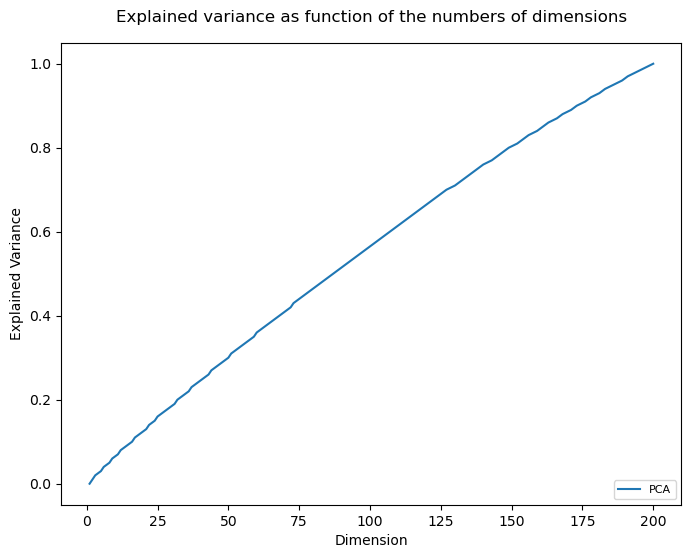

In [18]:
#Apply PCA
from sklearn.decomposition import PCA

#Apply PCA
pca=PCA(random_state=RANDOM_SEED)
pca.fit(X_tr.append(X_te))

#Analyze results
var_ratio_sum = np.cumsum(pca.explained_variance_ratio_)
threshold = np.arange(0.0, 1.01, 0.01, )
dimension = lambda threshold: np.argmax(var_ratio_sum>=threshold) + 1

#Plot
plt.figure(figsize=(8, 6))
plt.plot([dimension(x) for x in threshold],threshold, label = 'PCA')
plt.title('Explained variance as function of the numbers of dimensions', pad=15)
plt.ylabel('Explained Variance')
plt.xlabel('Dimension')
plt.legend(loc="lower right", fontsize=8)
plt.show()

__Observations:__ The results show no evident feature selections, non-linear PCI and LLE will be tested

# Baseline Classifiers
First I select simpler classifier and compare their performace then I try to use more complex ones  

Feature Similarity
* KNeighbors Classifier

Linear 
* Logistic Regressor 
* SGD Classifier
 
Ensemble Models
* Random Forest Classifier
* Gradient Boosting Classifier
* AdaBoost Classifier


In [19]:
#Controls execution
#RUN_KNEIGHBORS_CLASSIFIER = False
RUN_KNEIGHBORS_CLASSIFIER = True

#RUN_LOGISTIC_REGRESSOR = False
RUN_LOGISTIC_REGRESSOR = True

#RUN_SDG_CLASSIFIER = False
RUN_SDG_CLASSIFIER = True

### KNeighborsClassifier (baseline)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
KNeighborsClassifier Grid Search Training 0h:36m:30s
{'n_neighbors': 300}


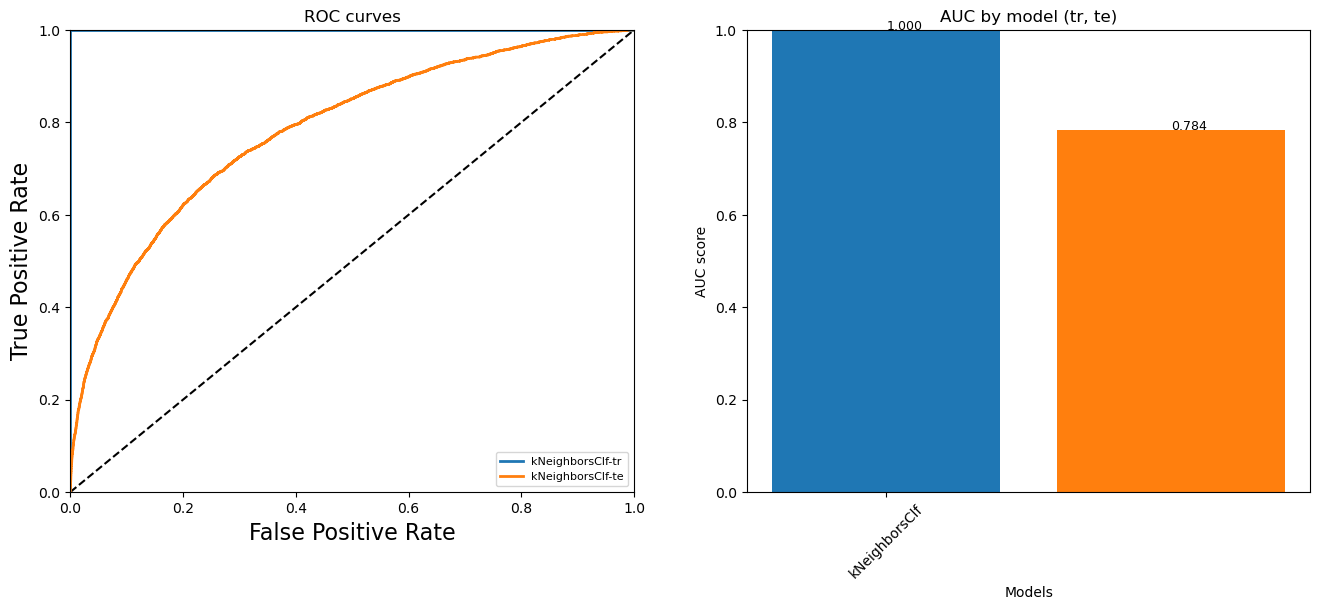

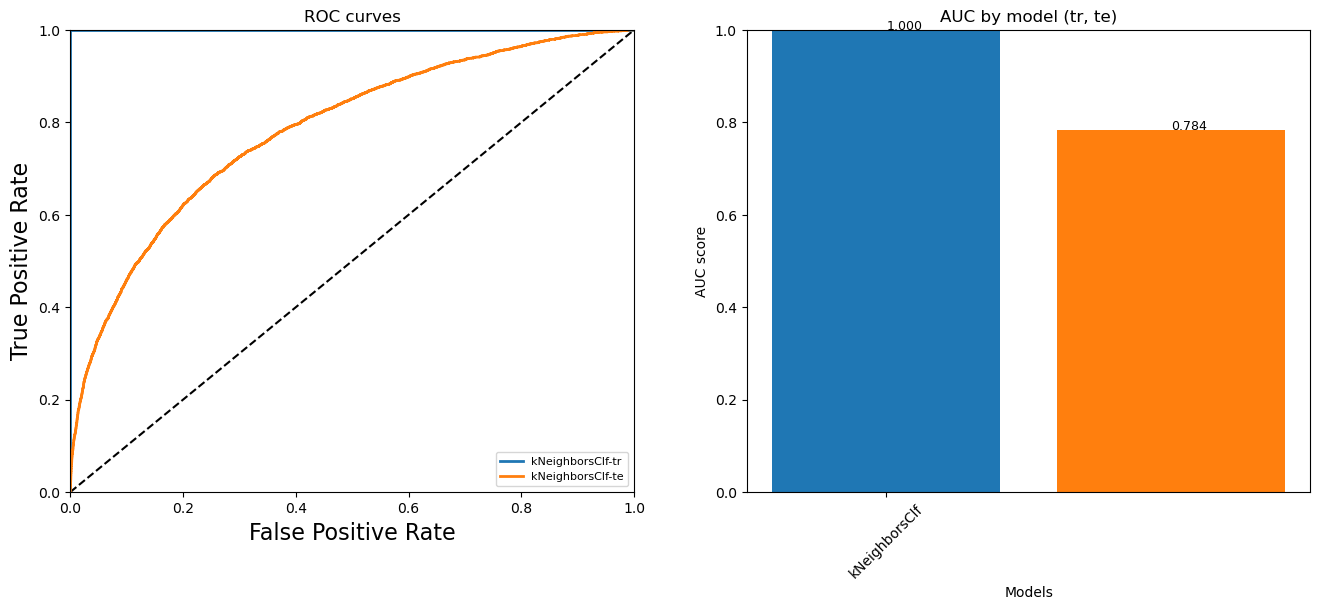

In [20]:
if RUN_KNEIGHBORS_CLASSIFIER:
       
    parameter_grid={
        "n_neighbors":[50, 100, 150, 300], 
    }
    start_timing()
    #Grid search
    kNeighborsClassifier = KNeighborsClassifier(weights='distance')
    grid_search= GridSearchCV(kNeighborsClassifier, param_grid=parameter_grid, cv=3, verbose=3, scoring = 'roc_auc', n_jobs=-1)
    grid_search.fit(X_tr, y_tr)  
    end_timing("KNeighborsClassifier Grid Search Training")

    #Print best parameters
    print(grid_search.best_params_ )

    #Select the best estimator
    kNeighborsClassifier= grid_search.best_estimator_ 

    #Save the model & search
    save_model(kNeighborsClassifier, 'kNeighborsClf')
    save_model(grid_search, 'kNeighborsClfGridSearch')

else:
    kNeighborsClassifier= load_model('kNeighborsClf') 

######################
if kNeighborsClassifier is not None:
    roc_models_add(kNeighborsClassifier, 'kNeighborsClf')
    plot_models_roc()
else:
    print("kNeighborsClassifier is not loaded or trained properly.")
#######################


#Plot the AUC
roc_models_add(kNeighborsClassifier, 'kNeighborsClf')

plot_models_roc()

Observations: Takes long time to train, about one hour each iteration

### Performance Measure KNeighborsClassifier

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Initialize the KNeighborsClassifier
knn = KNeighborsClassifier()

# Fit the KNeighborsClassifier on the training data
knn.fit(X_tr, y_tr)

# Predict the classes of the test set using the KNeighborsClassifier
knn_y_pred = knn.predict(X_te)

# Evaluate the performance of the KNeighborsClassifier using various evaluation metrics
cm = confusion_matrix(y_te, knn_y_pred)
accuracy = accuracy_score(y_te, knn_y_pred)
precision = precision_score(y_te, knn_y_pred, average='weighted')
recall = recall_score(y_te, knn_y_pred, average='weighted')
f1 = f1_score(y_te, knn_y_pred, average='weighted')

# Print the evaluation metrics
print("Confusion Matrix:\n", cm)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))


Confusion Matrix:
 [[35967    13]
 [ 4015     5]]
Accuracy: 89.93%
Precision: 83.71%
Recall: 89.93%
F1 Score: 85.21%


### Logistic Regressor (baseline)

Logistic Regressor Training 0h:0m:5s


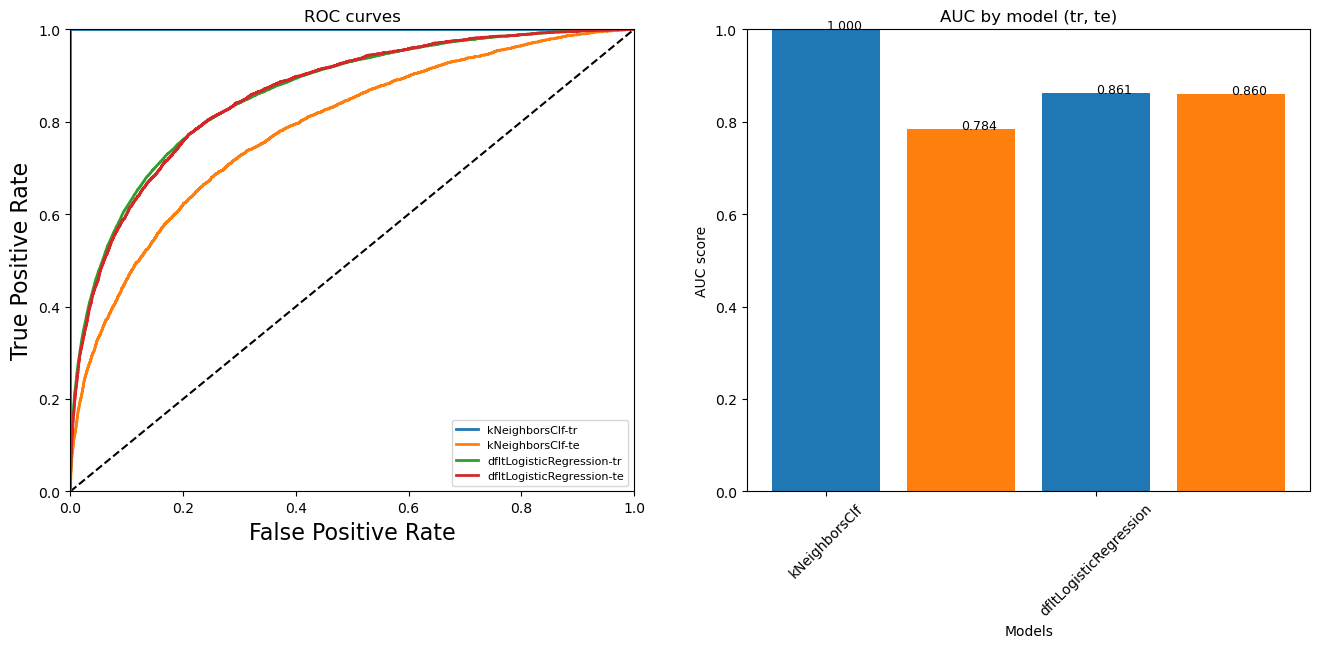

In [22]:
if RUN_LOGISTIC_REGRESSOR:
    #Train logistic regressor classifier
    start_timing()
    logisticRegression = LogisticRegression(random_state=RANDOM_SEED, solver='liblinear')
    logisticRegression.fit(X_tr, y_tr)  
    end_timing("Logistic Regressor Training")

    #Save the model
    save_model(logisticRegression, 'dfltLogisticRegression')
else:
    #Load the model
    logisticRegression = load_model('dfltLogisticRegression')

#Plot the AUC
roc_models_add(logisticRegression, 'dfltLogisticRegression')
plot_models_roc()

### Performance Measure LR

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming you have logisticRegression, X_te, and y_te defined
LR_y_pred = logisticRegression.predict(X_te)

#Confusion Matrix
cm = confusion_matrix(y_te, LR_y_pred)

#Accuracy
accuracy = accuracy_score(y_te, LR_y_pred)

#Precision: measures the proportion of true positive predictions out of all positive predictions made by the model.
precision = precision_score(y_te, LR_y_pred)

#Recall: measures the proportion of true positive predictions out of all actual positive instances.
recall = recall_score(y_te, LR_y_pred)

#F1 Score: is the harmonic mean of precision and recall, and provides a balanced measure of the model's performance.
f1 = f1_score(y_te, LR_y_pred)

print("Confusion Matrix:\n", cm)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))


Confusion Matrix:
 [[35500   480]
 [ 2991  1029]]
Accuracy: 91.32%
Precision: 68.19%
Recall: 25.60%
F1 Score: 37.22%


### SGDClassifier (baselilne)

SGDClassifier Training 0h:0m:2s


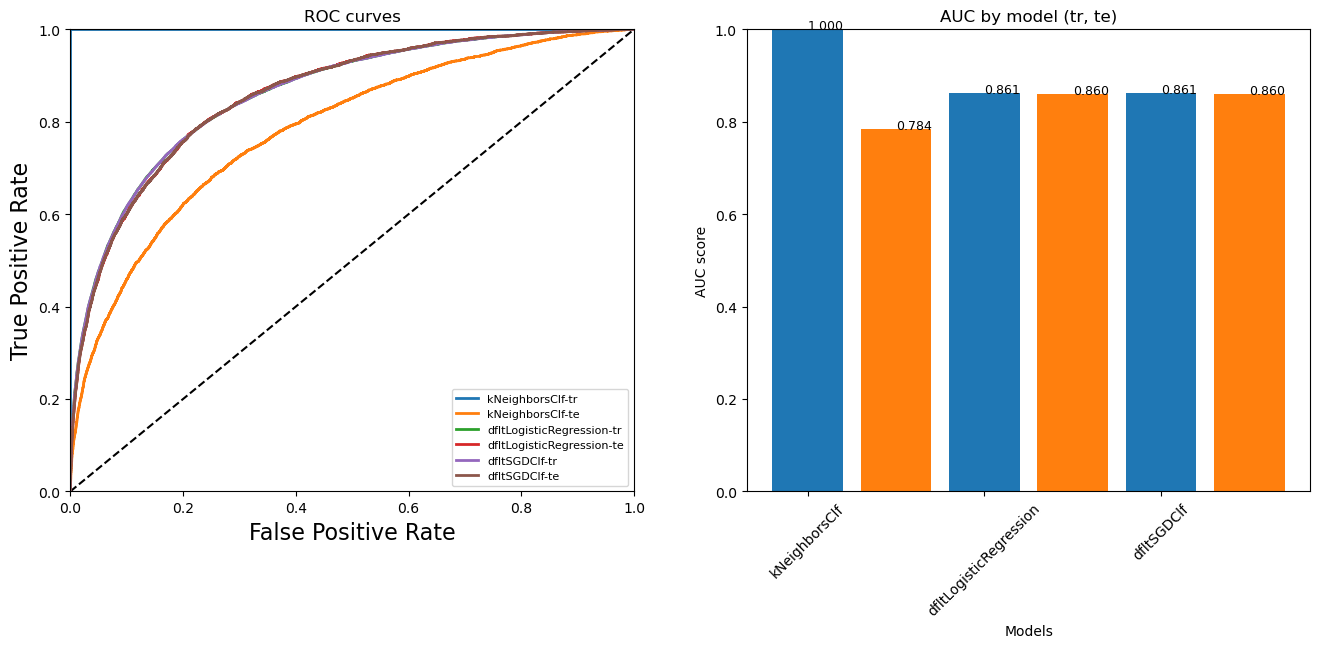

In [24]:
#Controls execution
if RUN_SDG_CLASSIFIER:
    start_timing()
    sgd_clf = SGDClassifier( loss='log', max_iter=200, tol =0.001, random_state=RANDOM_SEED)
    sgd_clf.fit(X_tr, y_tr)
    end_timing("SGDClassifier Training")

    #Save model
    save_model(sgd_clf, 'dfltSGDClf')
else:
     #Load the model
    sgd_clf = load_model('dfltSGDClf')
    
#Plot AUC
roc_models_add(sgd_clf, 'dfltSGDClf')
plot_models_roc()

### Performance Measure SGDClassifier

In [25]:
# Assuming you have logisticRegression, X_te, and y_te defined
#sgd_clf_y_pred = SGDClassifier.predict(X_te)
sgd_clf_y_pred = sgd_clf.predict(X_te)


#Confusion Matrix
cm = confusion_matrix(y_te, sgd_clf_y_pred)

#Accuracy
accuracy = accuracy_score(y_te, sgd_clf_y_pred)

#Precision: measures the proportion of true positive predictions out of all positive predictions made by the model.
precision = precision_score(y_te, sgd_clf_y_pred)

#Recall: measures the proportion of true positive predictions out of all actual positive instances.
recall = recall_score(y_te, sgd_clf_y_pred)

#F1 Score: is the harmonic mean of precision and recall, and provides a balanced measure of the model's performance.
f1 = f1_score(y_te, sgd_clf_y_pred)

print("Confusion Matrix:\n", cm)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

Confusion Matrix:
 [[35837   143]
 [ 3468   552]]
Accuracy: 90.97%
Precision: 79.42%
Recall: 13.73%
F1 Score: 23.41%


# Ensemble Models

In [26]:
#Controls execution
#RUN_RANDOM_FOREST_CLASSIFIER=False
#RUN_GRADIENT_BOOSTING_CLASSIFIER=False
#RUN_ADA_BOOST_CLASSIFIER=False

RUN_RANDOM_FOREST_CLASSIFIER=True
RUN_GRADIENT_BOOSTING_CLASSIFIER=True
RUN_ADA_BOOST_CLASSIFIER=True

### RandomForestClassifier (baseline)

RandomForestClassifier Training 0h:12m:44s


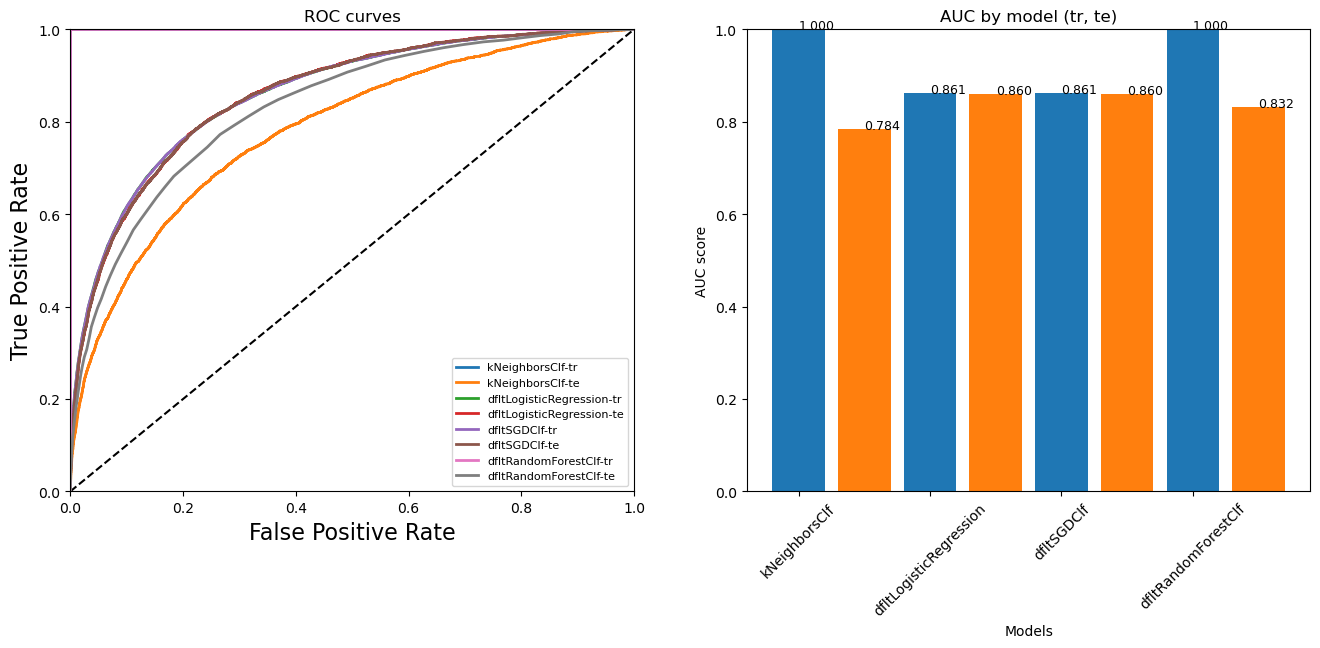

In [27]:
#Controls execution
if RUN_RANDOM_FOREST_CLASSIFIER:
    #Train random forest classifier
    start_timing()
    randomForestClassifier = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED, n_jobs = -1)
    randomForestClassifier.fit(X_tr, y_tr)
    end_timing("RandomForestClassifier Training")
    
    #Save the model
    save_model(randomForestClassifier, 'dfltRandomForestClf')
else:
    #Load the model
    randomForestClassifier = load_model('dfltRandomForestClf')
    
#Plot the AUC
roc_models_add(randomForestClassifier, 'dfltRandomForestClf')
plot_models_roc()

### Performance Measure Random Forest Classifier

In [28]:
# Assuming you have X_tr, y_tr, X_te, and y_te defined
#rfc = RandomForestClassifier(random_state=RANDOM_SEED)
#rfc.fit(X_tr, y_tr)

# Predict on the test set
rfc_y_pred = randomForestClassifier.predict(X_te)

# Calculate evaluation metrics
cm = confusion_matrix(y_te, rfc_y_pred)
accuracy = accuracy_score(y_te, rfc_y_pred)
precision = precision_score(y_te, rfc_y_pred)
recall = recall_score(y_te, rfc_y_pred)
f1 = f1_score(y_te, rfc_y_pred)

print("Confusion Matrix:\n", cm)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))


Confusion Matrix:
 [[35980     0]
 [ 4020     0]]
Accuracy: 89.95%
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### GradientBoostingClassifier (baseline)

GradientBoostingClassifier Training 0h:31m:57s


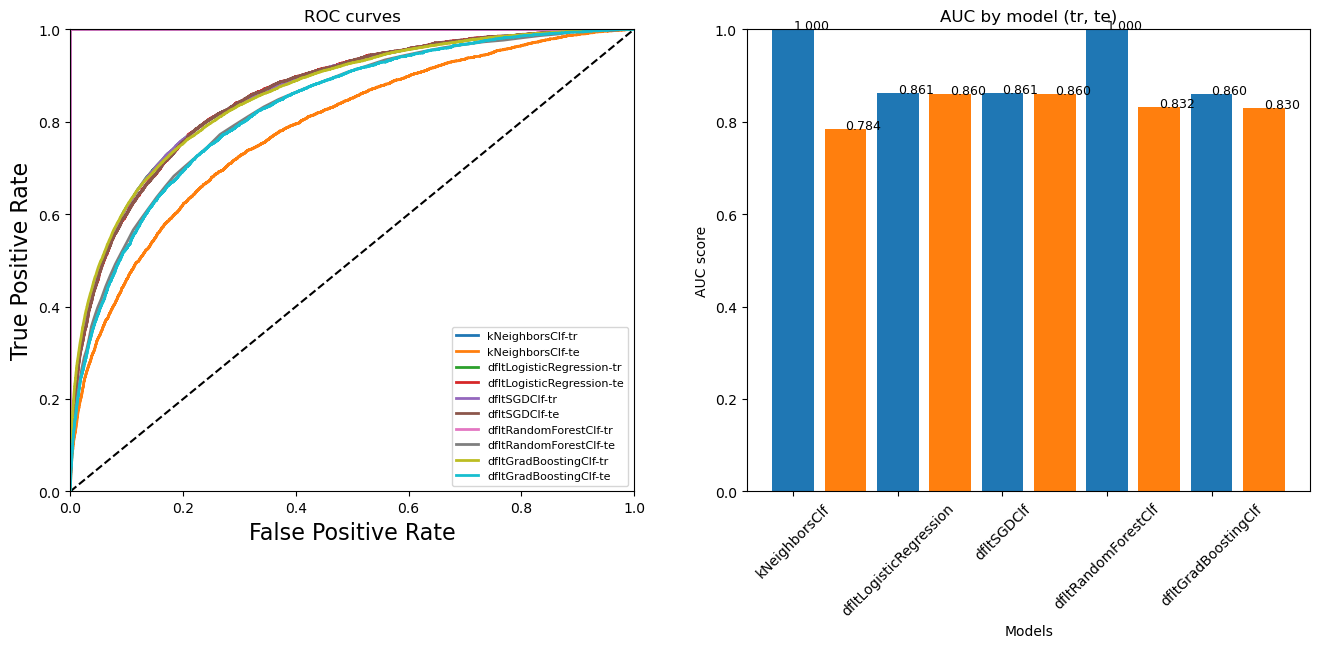

In [31]:
#Controls execution
if RUN_GRADIENT_BOOSTING_CLASSIFIER:

    #Train gradient boost classifier
    start_timing()
    gradientBoostingClassifier = GradientBoostingClassifier()
    gradientBoostingClassifier.fit(X_tr, y_tr)
    end_timing("GradientBoostingClassifier Training")

    #Save the model
    save_model(gradientBoostingClassifier, 'dfltGradBoostingClf')

else:
    #Load the model
    gradientBoostingClassifier = load_model('dfltGradBoostingClf')
    
#Plot the AUC
roc_models_add(gradientBoostingClassifier, 'dfltGradBoostingClf')
plot_models_roc()

### Performance Measure GRADIENT BOOSTING CLASSIFIER

In [32]:
# Assuming you have GradientBoostingClassifier, X_test, and y_test defined
#gb_clf = GradientBoostingClassifier()
#gb_clf.fit(X_tr, y_tr)
GBC_y_pred = gradientBoostingClassifier.predict(X_te)

# Confusion Matrix
cm = confusion_matrix(y_te, GBC_y_pred)

# Accuracy
accuracy = accuracy_score(y_te, GBC_y_pred)

# Precision
precision = precision_score(y_te, GBC_y_pred)

# Recall
recall = recall_score(y_te, GBC_y_pred)

# F1 Score
f1 = f1_score(y_te, GBC_y_pred)

print("Confusion Matrix:\n", cm)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))


Confusion Matrix:
 [[35961    19]
 [ 3904   116]]
Accuracy: 90.19%
Precision: 85.93%
Recall: 2.89%
F1 Score: 5.58%


### AdaBoostClassifier (baseline)

AdaBoostClassifier Training 0h:25m:15s


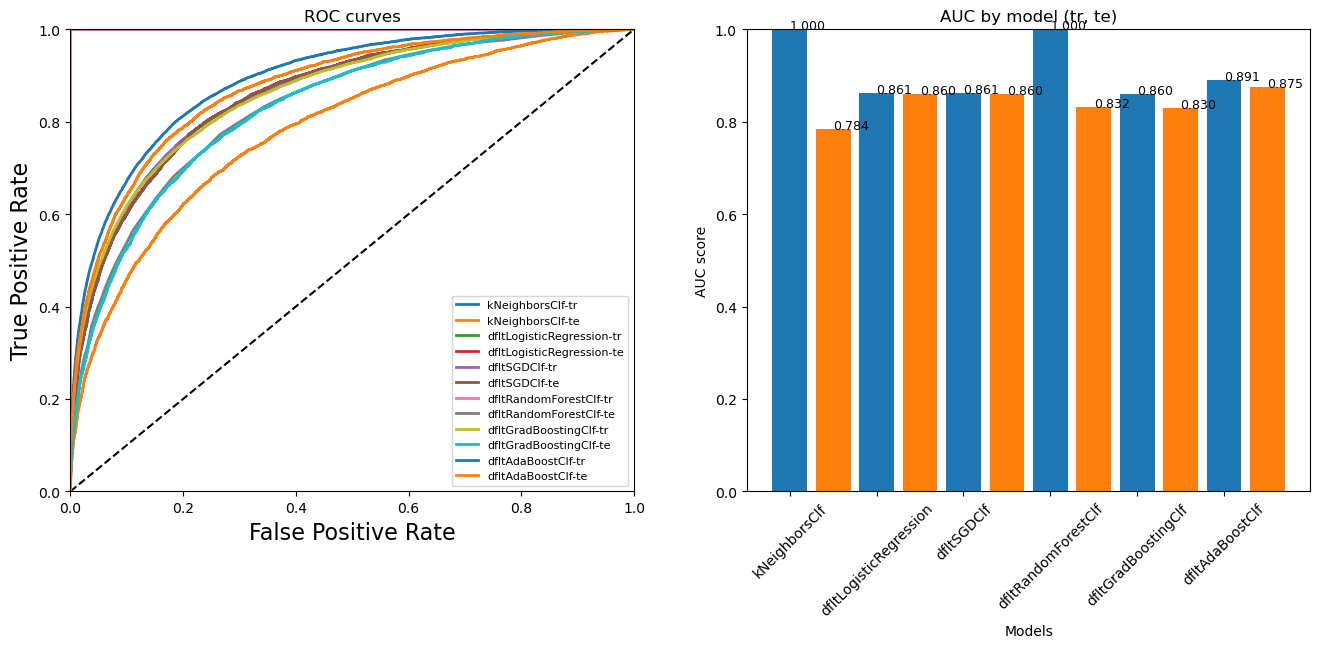

In [34]:
#Controls execution
if RUN_ADA_BOOST_CLASSIFIER:
    #Train AdaBoost classifier
    start_timing()
    adaBoostClassifier = AdaBoostClassifier(n_estimators=200, learning_rate=1)
    adaBoostClassifier.fit(X_tr, y_tr)
    end_timing("AdaBoostClassifier Training")

    #Save the model
    save_model(adaBoostClassifier, 'dfltAdaBoostClf')
else:
    #Load the model
    adaBoostClassifier = load_model('dfltAdaBoostClf')

#Plot the AUC
roc_models_add(adaBoostClassifier, 'dfltAdaBoostClf')
plot_models_roc()

### Performance Measure ADA BOOST CLASSIFIER

In [35]:
# Create an AdaBoostClassifier object and fit it to the training data
#ada_clf = AdaBoostClassifier(n_estimators=100, random_state=RANDOM_SEED)
#ada_clf.fit(X_train, y_train)

# Make predictions on the test data
ada_y_pred = adaBoostClassifier.predict(X_te)

# Calculate evaluation metrics
accuracy = accuracy_score(y_te, ada_y_pred)
precision = precision_score(y_te, ada_y_pred)
recall = recall_score(y_te, ada_y_pred)
f1 = f1_score(y_te, ada_y_pred)
conf_matrix = confusion_matrix(y_te, ada_y_pred)

print("Confusion Matrix:\n", cm)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

Confusion Matrix:
 [[35961    19]
 [ 3904   116]]
Accuracy: 91.70%
Precision: 66.46%
Recall: 35.20%
F1 Score: 46.02%


In [36]:
__Observations:__ It does look promising, will look further with grid search